In [1]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog, Label, Button, Entry
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN

import ipywidgets as widgets

from itertools import combinations, product

import random

from collections import Counter

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def see(img):
    plt.imshow(img)

In [3]:
def get_dominant_colors(img, k=4, rounds=1):
    pixels = img.reshape(-1, 3).astype(np.float32)
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(np.uint8)
    return colors

In [4]:
def auto_white_balance(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    avg_a = np.mean(a)
    avg_b = np.mean(b)
    
    a = a - ((avg_a - 128) * (l / 255.0) * 1.1)
    b = b - ((avg_b - 128) * (l / 255.0) * 1.1)
    
    a = np.clip(a, 0, 255).astype(np.uint8)
    b = np.clip(b, 0, 255).astype(np.uint8)
    
    balanced_lab = cv2.merge([l, a, b])
    return cv2.cvtColor(balanced_lab, cv2.COLOR_LAB2BGR)

In [5]:
def pdistance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

In [6]:
def check_aspect_ratio(corners, expected_ratio=1.5, tolerance=0.2):
    """Check for 3:2 (or 2:3) side ratio"""
    sides = sorted([
        pdistance(corners[0], corners[1]),
        pdistance(corners[1], corners[2]),
        pdistance(corners[2], corners[3]),
        pdistance(corners[3], corners[0])
    ])
    ratio = sides[3] / sides[0] if sides[0] != 0 else float('inf')
    return abs(ratio - expected_ratio) <= tolerance

In [7]:
def get_contours_by_mask(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    best_cnt = None
    C = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 30:
            C.append(cnt)
            # peri = cv2.arcLength(cnt, True)
            # approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            # if len(approx) == 4:  # Ищем четырехугольники
            #     if area > max_area:
            #         max_area = area
            #         best_cnt = approx
    
    print(len(C))
    return C

In [8]:
def show_contours(image, contours):
    cv2.drawContours(image, contours, -1, (255, 0, 0), 2)

In [9]:
def point_to_line_distance(line, point):
    x1, y1, x2, y2 = line
    px, py = point
    numerator = abs((y2 - y1)*px - (x2 - x1)*py + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

In [10]:
def draw_lines(image, lines, color, thickness=5):
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(image, (x1, y1), (x2, y2), color, thickness)

In [11]:
def langle(line):
    x1, y1, x2, y2 = line
    return np.degrees(np.atan2(y2 - y1, x2 - x1))

In [12]:
def line_polar_coords(line):
    x1, y1, x2, y2 = line
    angle = langle(line) % 180
    vx, vy = x2 - x1, y2 - y1
    norm = np.hypot(vx, vy)
    nx, ny = -vy / norm, vx / norm
    midx, midy = (x1 + x2) / 2, (y1 + y2) / 2
    rho = midx * nx + midy * ny
    return angle, rho

In [13]:
def cluster_lines_by_angle(lines, angle_threshold=10):
    clusters = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = langle(line[0])
        #print(f"[DEBUG]langle = {angle}")

        added = False
        for cluster in clusters:
            cluster_angle = cluster['angle']
            # print(f"[INSIDE] cluster_angle = {cluster_angle}")
            if abs(angle - cluster_angle) < angle_threshold:
                cluster['lines'].append((x1, y1, x2, y2))
                cluster['angles'].append(angle)
                added = True
                break

        if not added:
            clusters.append({
                'angle': angle,
                'lines': [(x1, y1, x2, y2)],
                'angles': [angle]
            })

    for cluster in clusters:
        cluster['angle'] = np.mean(cluster['angles'])

    return clusters

In [14]:
def cluster_lines_by_polar_coords(lines, angle_threshold=10, rho_threshold=20):
    clusters = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle_deg, rho = line_polar_coords(line[0])
        angle_rad = np.radians(angle_deg)

        added = False
        for cluster in clusters:
            cluster_angle = cluster['angle']
            cluster_rho = cluster['rho']

            if abs(angle_deg - cluster_angle) < angle_threshold and abs(rho - cluster_rho) < rho_threshold:
                cluster['lines'].append((x1, y1, x2, y2))
                cluster['angles'].append(angle_deg)
                cluster['rhos'].append(rho)
                added = True
                break

        if not added:
            clusters.append({
                'angle': angle_deg,
                'rho': rho,
                'lines': [(x1, y1, x2, y2)],
                'angles': [angle_deg],
                'rhos': [rho]
            })

    for cluster in clusters:
        cluster['angle'] = np.mean(cluster['angles'])
        cluster['rho'] = np.mean(cluster['rhos'])

    return clusters

In [15]:
def trapezoid_s_and_h(segment1, segment2, angle_tolerance=5):
    """
    Вычисляет площадь и высоту между двумя параллельными отрезками,
    даже если их проекции не перекрываются.
    Возвращает (0, 0) для непараллельных отрезков.
    """
    try:
        A = np.array([segment1[0], segment1[1]])
        B = np.array([segment1[2], segment1[3]])
        C = np.array([segment2[0], segment2[1]])
        D = np.array([segment2[2], segment2[3]])

        dir1 = B - A
        dir2 = D - C

        norm1 = np.linalg.norm(dir1)
        norm2 = np.linalg.norm(dir2)
        if norm1 < 1e-6 or norm2 < 1e-6:
            return 0.0, 0.0

        dir1_norm = dir1 / norm1
        dir2_norm = dir2 / norm2

        cos_angle = np.dot(dir1_norm, dir2_norm)
        angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))

        if angle > angle_tolerance and angle < (180 - angle_tolerance):
            return 0.0, 0.0

        if angle > 90:
            dir2_norm *= -1
            dir2 = dir2_norm * norm2

        avg_dir = (dir1_norm + dir2_norm) / 2
        avg_dir /= np.linalg.norm(avg_dir)

        normal = np.array([-avg_dir[1], avg_dir[0]])
        normal_norm = normal / np.linalg.norm(normal)

        AC = C - A
        h = abs(np.dot(AC, normal_norm))

        len1 = abs(np.dot(B - A, avg_dir))
        len2 = abs(np.dot(D - C, avg_dir))

        area = 0.5 * (len1 + len2) * h

        return area, h

    except Exception as e:
        print(f"Error: {str(e)}")
        return 0.0, 0.0

In [16]:
def line_to_line_distance(segment1, segment2, angle_tolerance=5):
    """
    Вычисляет высоту между двумя почти параллельными отрезками
    Возвращает 0.0 для непараллельных отрезков
    """
    try:
        A = np.array(segment1[:2])
        B = np.array(segment1[2:])
        C = np.array(segment2[:2])
        D = np.array(segment2[2:])
        
        dir1 = B - A
        dir2 = D - C
        
        norm1 = np.linalg.norm(dir1)
        norm2 = np.linalg.norm(dir2)
        if norm1 < 1e-6 or norm2 < 1e-6:
            return 0.0
        
        dir1_norm = dir1 / norm1
        dir2_norm = dir2 / norm2
        
        cos_angle = np.dot(dir1_norm, dir2_norm)
        angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
        
        if angle > angle_tolerance and angle < (180 - angle_tolerance):
            return 0.0
        
        if angle > 90:
            dir2_norm *= -1
        
        avg_dir = (dir1_norm + dir2_norm) / 2
        avg_dir /= np.linalg.norm(avg_dir)
        
        normal = np.array([-avg_dir[1], avg_dir[0]])
        normal_norm = normal / np.linalg.norm(normal)
        
        AC = C - A
        h = abs(np.dot(AC, normal_norm))
        
        return h
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return 0.0

In [17]:
def gypsy_pairs(clusters):
    """
    lets assume that card has 3:2 side ratio
    Hence, ((l1+l2)**2)/6 <= S <= 6x**2
    """
    pairs = []
    distances = []
    for cluster_id, cluster in enumerate(clusters):
        lines = cluster['lines']
        if len(lines) < 2:
            continue
            
        lengths = [pdistance((x1, y1), (x2, y2)) for x1, y1, x2, y2 in lines]
        
        sorted_lengths = sorted(lengths)
        l1_min, l2_min = sorted_lengths[:2]
        l1_max, l2_max = sorted_lengths[-2:]
        
        X = (l1_max + l2_max)/6
        S_min = ((l1_min + l2_min)**2)/6
        S_max = 6*X**2

        print(f"Cluster: {cluster_id}")
        print(f"S_min: {S_min}, S_max: {S_max}")
        print(f"X: {X}")
        print(f"l1_min, l2_min: {l1_min}, {l2_min}")
        print(f"l1_max, l2_max: {l1_max}, {l2_max}")
        
        for i in range(len(lines)):
            for j in range(i + 1, len(lines)):
                # h must be: h >= 2x
                s, h = trapezoid_s_and_h(lines[i], lines[j])
                if s == 0 or h < 2*X or not (S_min <= s <= S_max):
                    continue
                pairs.append((cluster_id, lines[i], lines[j], h))
                print(f"[INSIDE] cluster_id_{cluster_id}: s = {s}, h = {h}")
                distances.append(h)
    return pairs, distances

In [18]:
def get_all_rois(img, contours, max_cols=4, figsize=(12, 8)):
    n = len(contours)
    MIN_AREA = 100 * 150
    rois = []
    if n == 0:
        print("Нет контуров для отображения")
        return

    n_rows = (n + max_cols - 1) // max_cols
    n_cols = min(n, max_cols)
    
    plt.figure(figsize=figsize)
    
    for i, cont in enumerate(contours, 1):
        m = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(m, [cont], -1, 255, thickness=-1)
        masked_img = cv2.bitwise_and(img, img, mask=m)
        
        x, y, w, h = cv2.boundingRect(cont)
        roi = masked_img[y:y+h, x:x+w].copy()
        
        if len(roi.shape) == 3 and roi.shape[2] == 3:
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

        rh, rw = roi.shape[:2]
        if rh < 50 or h < 50:
            print("SMALL 1")
            continue
        elif rh * rw < MIN_AREA * 0.7:
            print("SMALL (AREA) 2")
            continue
        else:
            rois.append(roi)
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(roi)
        plt.axis('off')
        plt.title(f'ROI {i}')

    plt.tight_layout()
    plt.show()
    return rois

In [168]:
def show_all_centers(rois, max_cols=4, figsize=(12, 8)):
    n = len(rois)
    MIN_AREA = 100 * 150
    if len(rois) == 0:
        print("No ROIS")
        return
        
    n_rows = (n + max_cols - 1) // max_cols
    n_cols = min(n, max_cols)
    
    plt.figure(figsize=figsize)
    
    for i, r in enumerate(rois, 1):
        # check for size
        rh, rw = r.shape[:2]
        if rh < 50 or rh < 50:
            print("SMALL 1")
            continue

        if rh * rw < MIN_AREA * 0.7:
            print("SMALL (AREA) 2")
            continue

        
        r = auto_white_balance(r)
        gray = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
        
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
        enhanced = clahe.apply(gray)

        ####
        mean, stddev = cv2.meanStdDev(enhanced)
        brightness = mean[0][0]
        contrast = stddev[0][0]
        
        if brightness < 100 and contrast < 50:
            enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=0)
        ####
        
        # enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=0)
        # see(enhanced)
        
        enhanced = cv2.GaussianBlur(enhanced, (5, 5), 0)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        morph = cv2.morphologyEx(enhanced, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        # see(morph)
        
        enhanced = morph
        
        i_c = r.copy()
        
        nn = cv2.Canny(enhanced, 50, 150)
        # see(nn)
        contours = get_contours_by_mask(nn)
        # show_contours(i_c, contours)
        cv2.drawContours(i_c, contours, -1, 255, thickness=1)
        # see(i_c)
        
        i_test = r.copy()
        i_viz = r.copy()
        
        for c_t in contours:
            show_contours(i_test, c_t)
            # see(i_test)
            M = cv2.moments(c_t)
            if M["m00"] == 0:
                cx, cy = 0, 0
            else:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            
            points = c_t[:, 0, :]
            center = np.array([cx, cy])
            dists = np.linalg.norm(points - center, axis=1)
            
            for (x, y), d in zip(points, dists):
                cv2.circle(i_viz, (x, y), 1, (0, 255, 0), -1)
            
            cv2.circle(i_viz, (cx, cy), 4, (255, 0, 255), -1) # center
            # see(i_viz)
            # area = cv2.contourArea(c_t) 
            # perim = cv2.arcLength(c_t, True)
            # compactness = (perim ** 2) / (4 * np.pi * area + 1e-6)
            # print(f"perim {perim}, comp {compactness}")
            # approx = cv2.approxPolyDP(c_t, 0.01 * perim, True)
            # num_vertices = len(approx)
            # print(num_vertices)
            
            # is_convex = cv2.isContourConvex(c_t)
            # print(is_convex)
            # hull = cv2.convexHull(c_t)
            # show_contours(i_test, hull)
            # cv2.drawContours(i_test, [hull], -1, (0, 255, 0), 2)
            # see(i_test)
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(i_viz)
        plt.axis('off')
        plt.title(f'center {i}')
        
    plt.tight_layout()
    plt.show()

In [20]:
nums = [1, 2, 4, 6, 7, 9, 10]
image_selector = widgets.RadioButtons(
    options=[f'./images/IMG_{i}.jpg' for i in nums],
    description='Select Image:'
)

display(image_selector)

RadioButtons(description='Select Image:', options=('./images/IMG_1.jpg', './images/IMG_2.jpg', './images/IMG_4…

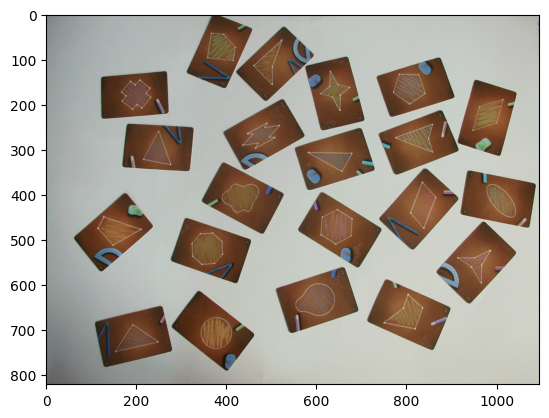

In [135]:
img = cv2.imread(image_selector.value)
img_orig = img.copy()
img = auto_white_balance(img)
# get_dominant_colors(img)
see(img)

# Найдем базовую маску (т.е. отделим карты от фона) BASED MASK

In [136]:
# lower and upper bound for "blue"
lower_blue = np.array([80, 40, 40])
upper_blue = np.array([130, 255, 255])
# mask for blue
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower_blue, upper_blue)

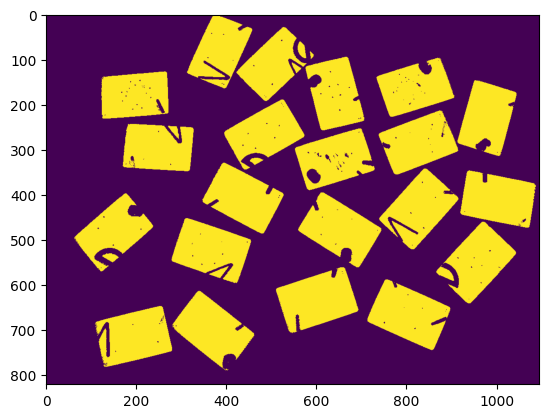

In [137]:
see(mask)

In [138]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
# mask = cv2.medianBlur(mask, 3)

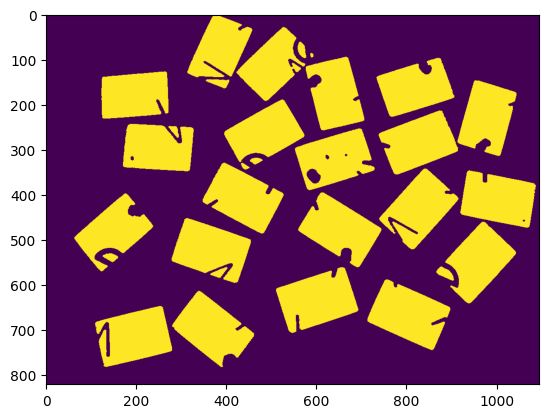

In [139]:
see(mask)

In [140]:
# TEST
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# mask = cv2.dilate(mask, kernel, iterations=2)
# mask = cv2.erode(mask, kernel, iterations=2)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# mask = cv2.dilate(mask, kernel, iterations=3)
# mask = cv2.erode(mask, kernel, iterations=3)

# dilate -> erode -> erode -> dilate
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
# 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# mask = cv2.dilate(mask, kernel, iterations=2)
# mask = cv2.erode(mask, kernel, iterations=3)

# mask = cv2.medianBlur(mask, 3)
# TEST

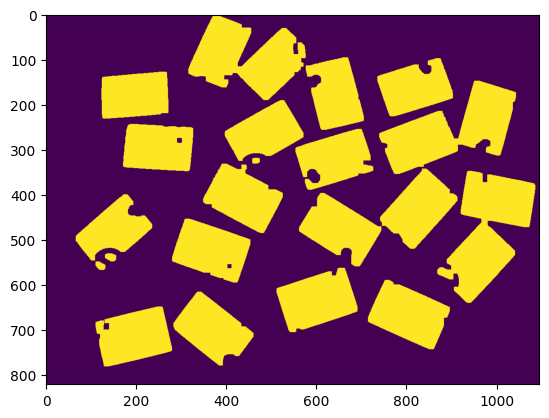

In [141]:
see(mask)

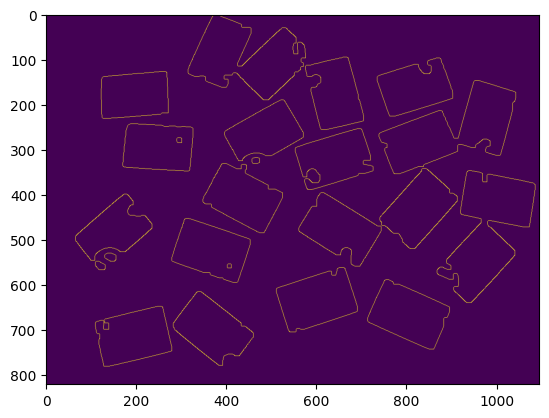

In [142]:
base_mask = mask
edges_base_mask = cv2.Canny(base_mask, 50, 150)
see(edges_base_mask)

# [exper] Попробуем WATERSHED для разделения "слипшихся карточек"

## 1st version (working)

In [143]:
ret, sure_fg = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
dist_transform = cv2.distanceTransform(sure_fg, cv2.DIST_L2, 5)

In [144]:
ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

In [145]:
sure_bg = cv2.dilate(mask, kernel, iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

[[-1 -1 -1 ... -1 -1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


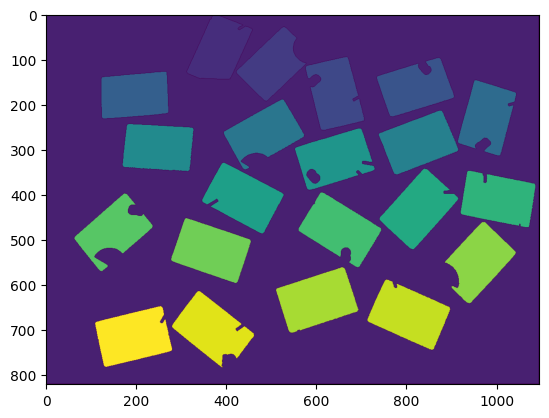

In [146]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
see(markers)
print(markers)

# 2nd version (testing...)

[[-1 -1 -1 ... -1 -1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


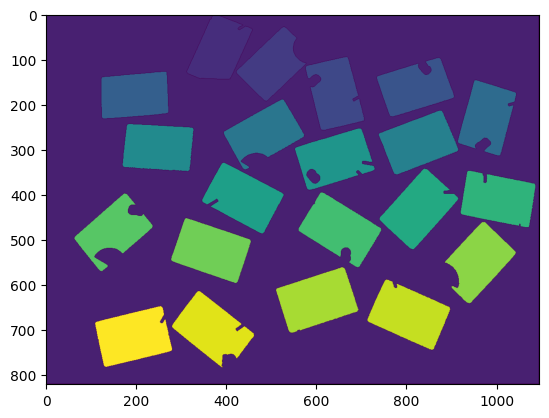

In [147]:
kernel = np.ones((5,5), np.uint8)
sure_bg = cv2.dilate(mask, kernel, iterations=3)
eroded = cv2.erode(mask, kernel, iterations=2)
dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)

see(markers)
print(markers)
print(eroded)

In [148]:
C = get_contours_by_mask(mask)

21


По 3 перпенд. прямым можно точно определить прямоугольник, храня сренднее зн. площади
если площадь `(s_mean - s[i]) / s_mean <= 0.3)` то все ок. Иначе средняя сторона -- точно $b$ (т.е. меньшая)

# Найдем контуры карточек

21


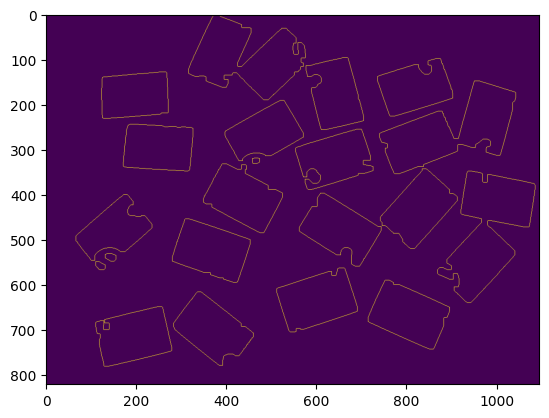

In [149]:
C = get_contours_by_mask(base_mask)
C_mask = np.zeros_like(base_mask)
cv2.drawContours(C_mask, C, -1, 255, thickness=1)
see(C_mask)

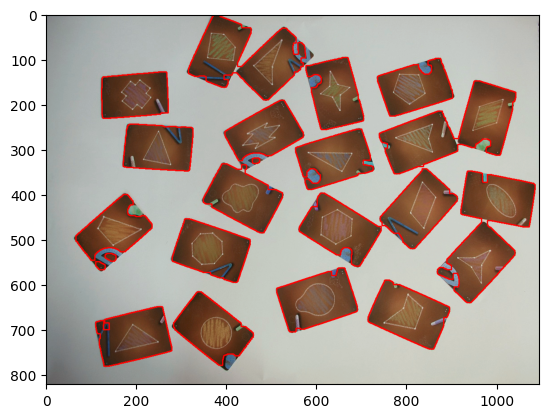

In [150]:
img_c = img.copy()
show_contours(img_c, C)
see(img_c)

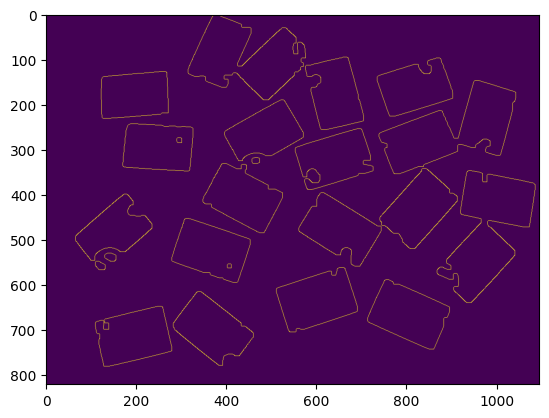

In [151]:
edges = cv2.Canny(base_mask, 50, 150)
# edges = cv2.Canny(C_mask, 50, 150)
see(edges)

# EXPER EXPER

In [152]:
def extract_figures_in_contour(image, cnt, min_area=50):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    # cv2.drawContours(mask, [cnt], -1, 255, -1)
    cv2.drawContours(mask, [cnt], -1, 255, thickness=1)

    inner = cv2.bitwise_and(image, image, mask=mask)
    gray = cv2.cvtColor(inner, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, bin_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    inner_contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output = image.copy()
    extracted = []

    for ic in inner_contours:
        area = cv2.contourArea(ic)
        if area < min_area:
            continue 

        if len(ic) >= 5:
            ellipse = cv2.fitEllipse(ic)
            (xc, yc), (w, h), angle = ellipse
            roi = extract_ellipse_patch(image, ellipse)
            extracted.append(roi)

            if visualize:
                cv2.ellipse(output, ellipse, (0, 255, 0), 2)
        else:
            x, y, w, h = cv2.boundingRect(ic)
            roi = image[y:y+h, x:x+w]
            extracted.append(roi)

    return extracted

In [169]:
ii = img_orig.copy()

SMALL 1
SMALL 1
SMALL 1


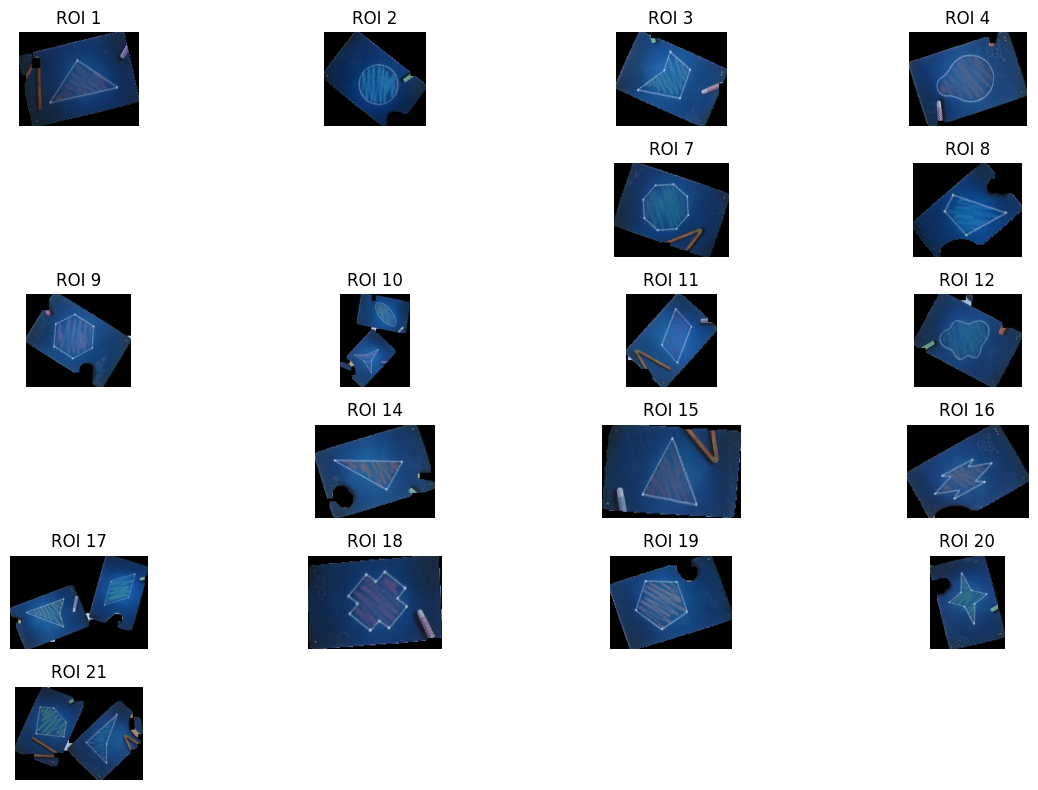

In [170]:
rois = get_all_rois(ii, C)

2
5
4
1
2
3
4
7
4
4
2
1
6
4
2
1
1
7


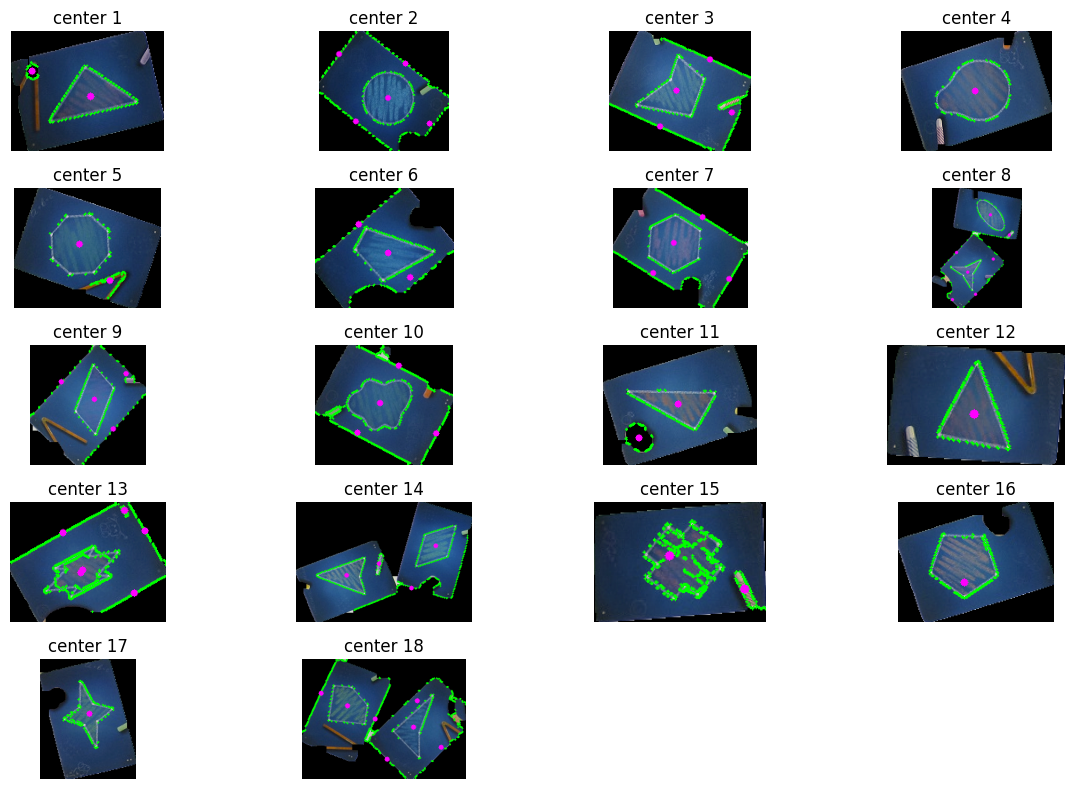

In [171]:
show_all_centers(rois)

2


array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [42, 52, 50],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [71, 75, 72],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], shape=(104, 149, 3), dtype=uint8)

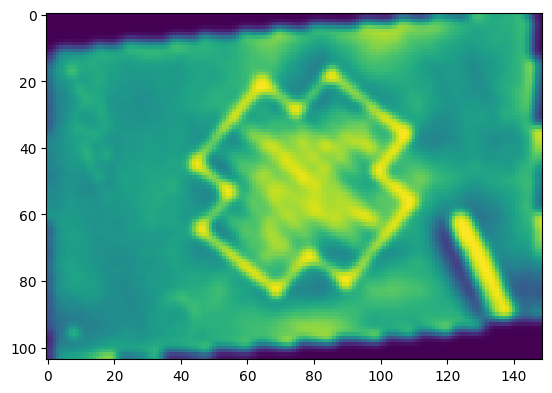

In [174]:
roi = rois[14]
see(roi)
roi = auto_white_balance(roi)

gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
enhanced = clahe.apply(gray)

####
mean, stddev = cv2.meanStdDev(enhanced)
brightness = mean[0][0]
contrast = stddev[0][0]

if brightness < 100 and contrast < 50:
    enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=0)
####

# enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=0)
# see(enhanced)

enhanced = cv2.GaussianBlur(enhanced, (5, 5), 0)

see(enhanced)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morph = cv2.morphologyEx(enhanced, cv2.MORPH_CLOSE, kernel, iterations=2)

# see(morph)

enhanced = morph

i_c = roi.copy()

nn = cv2.Canny(enhanced, 50, 150)
# see(nn)
contours = get_contours_by_mask(nn)
# show_contours(i_c, contours)
cv2.drawContours(i_c, contours, -1, 255, thickness=1)
# see(i_c)


i_test = roi.copy()
c_t = contours[1]
show_contours(i_test, c_t)
# see(i_test)

M = cv2.moments(c_t)
if M["m00"] == 0:
    cx, cy = 0, 0  # безопасно
else:
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

points = c_t[:, 0, :]
center = np.array([cx, cy])
dists = np.linalg.norm(points - center, axis=1)

i_viz = roi.copy()
for (x, y), d in zip(points, dists):
    cv2.circle(i_viz, (x, y), 1, (0, 255, 0), -1)

cv2.circle(i_viz, (cx, cy), 4, (0, 0, 255), -1) # center
# see(i_viz)
# area = cv2.contourArea(c_t) 
# perim = cv2.arcLength(c_t, True)
# compactness = (perim ** 2) / (4 * np.pi * area + 1e-6)
# print(f"perim {perim}, comp {compactness}")
# approx = cv2.approxPolyDP(c_t, 0.01 * perim, True)
# num_vertices = len(approx)
# print(num_vertices)

# is_convex = cv2.isContourConvex(c_t)
# print(is_convex)
# hull = cv2.convexHull(c_t)
# show_contours(i_test, hull)
# cv2.drawContours(i_test, [hull], -1, (0, 255, 0), 2)
# see(i_test)

In [ ]:
# find peaks
min_dist_between_peaks = 5
peaks, _ = find_peaks(dists, distance=min_dist_between_peaks, prominence=5)
i_peaks = roi.copy()

for idx in peaks:
    x, y = points[idx]
    cv2.circle(i_peaks, (x, y), 5, (0, 255, 0), -1)

cv2.circle(i_peaks, (cx, cy), 4, (0, 0, 255), -1)
see(i_peaks)

In [ ]:
lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
h, w, _ = lab.shape
lab_flat = lab.reshape((-1, 3))

kmeans = KMeans(n_clusters=10, n_init=15, random_state=42)
labels = kmeans.fit_predict(lab_flat)
labels_img = labels.reshape((h, w))


In [ ]:
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

lower_white = np.array([0, 0, 10])
upper_white = np.array([180, 50, 255])

chalk_mask = cv2.inRange(hsv_roi, lower_white, upper_white)
see(chalk_mask)

In [ ]:
gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
gray_roi = cv2.medianBlur(gray_roi, 5)
# _, bin_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Адаптивный порог: локальный контраст, работает даже при плохом освещении
bin_roi = cv2.adaptiveThreshold(
    gray_roi, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV,  # инверсия сразу
    blockSize=31,  # локальный размер окна (нечётное число)
    C=0
)

bin_roi = 255 - bin_roi
see(gray_roi)
see(bin_roi)

In [ ]:
inner_contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
roi_copy = roi.copy()
cv2.drawContours(roi_copy, inner_contours[10], -1, (0, 255, 0), 2)
see(roi_copy)

In [ ]:
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=10,  minLineLength=10, maxLineGap=10)

In [ ]:
line_image = img.copy()
draw_lines(line_image, lines.reshape(-1, 4), [255, 0, 0])

In [ ]:
see(line_image)

In [ ]:
ll_img = np.zeros_like(base_mask)
draw_lines(ll_img, lines.reshape(-1, 4), [255, 0, 0], thickness=1)
new_edges = cv2.Canny(ll_img, 50, 150)

In [ ]:
see(new_edges)

In [ ]:
new_lines = cv2.HoughLinesP(new_edges, rho=1, theta=np.pi/180, threshold=10,  minLineLength=10, maxLineGap=10)

In [ ]:
new_img = img.copy()
draw_lines(new_img, new_lines.reshape(-1, 4), [255, 0, 0], thickness=3)
see(new_img)
lines = new_lines

# Разобьем на отрезки на кластеры

Нам нужно получить группы паралелльных линий для всего изображения

Когда мы это сделаем, мы сможем их как-нибудь обрабатывать.

In [ ]:
ANGLE_TOLERANCE = 5
RHO_TOLERANCE = 10

In [ ]:
if lines is None:
    print("Линий не найдено")
else:
    clusters = cluster_lines_by_angle(lines, ANGLE_TOLERANCE)

    clustered_img = img.copy()
    colors = [(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)) for _ in range(len(clusters))]

    for idx, cluster in enumerate(clusters):
        draw_lines(clustered_img, np.array(cluster['lines']), colors[idx])

    print(f"Найдено кластеров: {len(clusters)}")

In [ ]:
def merge_cluster_to_line(cluster):
    lines = cluster['lines']
    angle_deg = cluster['angle']
    angle_rad = np.radians(angle_deg)
    
    dx = np.cos(angle_rad)
    dy = np.sin(angle_rad)
    direction = np.array([dx, dy])
    
    points = []
    for x1, y1, x2, y2 in lines:
        points.append((x1, y1))
        points.append((x2, y2))
    
    projections = []
    for x, y in points:
        point = np.array([x, y])
        proj = np.dot(point, direction)
        projections.append((proj, (x, y)))

    projections.sort()
    start_point = projections[0][1]
    end_point = projections[-1][1]
    
    return (*start_point, *end_point)  # x1, y1, x2, y2

In [ ]:
see(clustered_img)

In [ ]:
see(clustered_img_1)

In [ ]:
merged_lines = []
for cluster in clusters:
    merged_line = merge_cluster_to_line(cluster)
    merged_lines.append(merged_line)

img_m = img.copy()
draw_lines(img_m, merged_lines, [255, 255, 0], 5)

In [ ]:
see(img_m)

In [ ]:
print(f"[DEBUG] Всего кластеров: {len(clusters)}")
for i, cl in enumerate(clusters):
    print(f"  Кластер {i}: угол={cl['angle']:.2f}, кол-во линий={len(cl['lines'])}")

# [exper] Попробуем (зачем-то) найти средний размер карточки (т.е. a и b)

## GYPSY TRY

In [ ]:
pairs, dists = gypsy_pairs(clusters)

In [ ]:
dists_norm = (dists - np.min(dists)) / (np.max(dists) - np.min(dists))
counts, bins, patches = plt.hist(dists_norm, bins=100)

bin_centers = (bins[:-1] + bins[1:]) / 2
min_peak_distance = 0.03
distance_in_bins = int(min_peak_distance * len(bin_centers))

peaks, _ = find_peaks(counts, distance=distance_in_bins)

top_two_peaks = np.sort(counts[peaks])[-5:]
print(top_two_peaks)
print(f"len(dists): {len(dists)}")

In [ ]:
def visualize_dbscan_on_distances(distances, eps=30, min_samples=10):
    distances = np.array(distances).reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(distances)
    labels = clustering.labels_

    # Подготовим цвета
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(12, 6))
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(np.where(mask)[0], distances[mask], label=f'Кластер {label}', color=color, s=10)

    plt.title("DBSCAN кластеризация расстояний между линиями")
    plt.xlabel("Индекс пары")
    plt.ylabel("Расстояние между линиями")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return labels

In [ ]:
def find_optimal_eps(dists, min_samples, target_ratio=2/3, tolerance=0.05):
    dists = np.asarray(dists).reshape(-1, 1)
    
    for eps in np.arange(1.0, 10.1, 0.5):
        labels = visualize_dbscan_on_distances(dists, eps=eps, min_samples=min_samples)
        unique_labels = np.unique(labels[labels != -1])
        
        if len(unique_labels) < 2:
            continue
            
        cluster_means = []
        for label in unique_labels:
            mask = (labels == label).flatten()
            cluster_data = dists[mask]
            if len(cluster_data) > 5:
                cluster_means.append(np.mean(cluster_data))
        
        cluster_means = sorted(cluster_means)
        for i in range(len(cluster_means)):
            for j in range(i+1, len(cluster_means)):
                ratio = cluster_means[i] / cluster_means[j]
                if abs(ratio - target_ratio) <= tolerance:
                    print(f"Найден оптимальный eps: {eps:.1f}")
                    print(f"Кластеры: {cluster_means[i]:.2f} и {cluster_means[j]:.2f}")
                    print(f"Соотношение: {ratio:.2f} (цель: {target_ratio:.2f})")
                    return cluster_means[i], cluster_means[j], eps
    return None

## Версия С подбором $\varepsilon$

In [ ]:
print(f"top_two_peaks: {top_two_peaks}")
min_samples = int(min(top_two_peaks))

In [ ]:
a1, a2, E = find_optimal_eps(dists, min_samples=min_samples)
print(f"a1 = {a1}, a2 = {a2}, eps = {E}")

# Теперь найдем сами карточки (т.е. пересечения перпендикулярных кластеров)

In [ ]:
def point_side_of_line(p, a, b):
    return np.sign((b[0] - a[0])*(p[1] - a[1]) - (b[1] - a[1])*(p[0] - a[0]))
    
def is_segment_inside_strip(a, b, c):
    # a, b, c — отрезки вида [(x1, y1), (x2, y2)]
    a1, a2 = (a[0], a[1]), (a[2], a[3])
    b1, b2 = (b[0], b[1]), (b[2], b[3]) 
    c1, c2 = (c[0], c[1]), (c[2], c[3])

    side_c1_a = point_side_of_line(c1, a1, a2)
    side_c2_a = point_side_of_line(c2, a1, a2)

    side_c1_b = point_side_of_line(c1, b1, b2)
    side_c2_b = point_side_of_line(c2, b1, b2)

    if side_c1_a != side_c2_a or side_c1_b != side_c2_b:
        return False

    return side_c1_a != side_c1_b and side_c2_a != side_c2_b

In [ ]:
def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    if abs(denom) < 1e-6:
        return None

    px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
    py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom
    return np.array([px, py])

In [ ]:
def mark_best_perp_intersections(img, G1, G2, angle_tolerance=10):
    img_copy = img.copy()
    radius = 6

    G1_lines = G1['lines']
    G2_lines = G2['lines']

    for i in range(len(G1_lines)):
        for j in range(i + 1, len(G1_lines)):
            a = G1_lines[i]
            b = G1_lines[j]
            best = None
            min_sum = float('inf')

            for c in G2_lines:
                ca_d1 = point_to_line_distance(a, (c[0], c[1]))
                ca_d2 = point_to_line_distance(a, (c[2], c[3]))
                cb_d1 = point_to_line_distance(b, (c[0], c[1]))
                cb_d2 = point_to_line_distance(b, (c[2], c[3]))

                ca = min(ca_d1, ca_d2)
                cb = min(cb_d1, cb_d2)

                c_size = pdistance((c[0], c[1]), (c[2], c[3]))

                # ABABABAB
                ab_dist = line_to_line_distance(a, b, angle_tolerance=angle_tolerance)
                

                if not ((ca <= (ab_dist*1.1 - c_size)) and
                        (cb <= (ab_dist*1.1 - c_size))):
                    # print(f"POPALSA!")
                    continue
                    
                # if not ((ca <= max(a1, a2)*1.1 - c_size) and
                #         (cb <= max(a2, a2)*1.1 - c_size)):
                #     # print(f"POPALSA!")
                #     continue

                # STRIP STRIP
                if not is_segment_inside_strip(c, a, b):
                    continue
                # STRIP STRIP
                
                # lets find out the exact p of start for both
                a_d1 = point_to_line_distance(c, (a[0], a[1]))
                a_d2 = point_to_line_distance(c, (a[2], a[3]))
                b_d1 = point_to_line_distance(c, (b[0], b[1]))
                b_d2 = point_to_line_distance(c, (b[2], b[3]))

                if a_d1 < a_d2:
                    a_start = (a[0], a[1])
                else:
                    a_start = (a[2], a[3])
                    
                if b_d1 < b_d2:
                    b_start = (b[0], b[1])
                else:
                    b_start = (b[2], b[3])

                #
                
                # if not ((a_d1 > 1 and a_d2 > 1) and (b_d1 > 1 and b_d2 > 1)):
                #     print(f"SHIT HAPPEND: {a_d1} or {a_d2} or {b_d1} or {b_d2}")
                
                m1 = line_intersection(a, c)
                m2 = line_intersection(b, c)
                
                if m1 is None or m2 is None:
                    print(f"NO INTER: {m1}, {m2}")
                    continue

                dist1 = pdistance(m1, a_start)
                dist2 = pdistance(m2, b_start)

                #####
                if not ((dist1 <= max(a1, a2)*1.1) and
                        (dist2 <= max(a1, a2)*1.1)):
                    continue
                    
                m1m2 = pdistance(m1, m2)
                
                if not (min(a1, a2)*0.7 <= m1m2 <= max(a1, a2)*1.3):
                    continue
                if not (ab_dist*0.95 <= m1m2 <= ab_dist*1.05):
                    continue
                
                m1 = tuple(map(int, m1))
                m2 = tuple(map(int, m2))
                cv2.circle(img_copy, m1, radius, (0, 255, 0), -1)
                cv2.circle(img_copy, m2, radius, (255, 0, 0), -1)
                cv2.line(img_copy, m1, m2, (0, 0, 255), 5)
                # cv2.line(img_copy, a_start, m1, (100, 0, 255), 5)
                # cv2.line(img_copy, b_start, m2, (100, 0, 255), 5)
                
                  
                #####
#                 score = dist1 + dist2
#                 if score < min_sum:
#                     min_sum = score
#                     best = (m1, m2)
# 
#             if best:
#                 m1, m2 = best
#                 m1 = tuple(map(int, m1))
#                 m2 = tuple(map(int, m2))
#                 cv2.circle(img_copy, m1, radius, (0, 255, 0), -1)
#                 cv2.circle(img_copy, m2, radius, (255, 0, 0), -1)
#                 cv2.line(img_copy, m1, m2, (0, 0, 255), 5)
#                 # cv2.line(img_copy, a_start, m1, (100, 0, 255), 5)
#                 # cv2.line(img_copy, b_start, m2, (100, 0, 255), 5)
                
    return img_copy

In [ ]:
output = img.copy()

for i, G1 in enumerate(clusters):
    for j, G2 in enumerate(clusters):
        if i >= j:
            continue

        angle1 = G1['angle']
        angle2 = G2['angle']
        angle_diff = abs((angle1 - angle2 + 180) % 180 - 90)

        # +- ANGANGLE_TOLERANCE
        if angle_diff <= ANGLE_TOLERANCE: 
            print(f"[DEBUG] G1 #{i} (angle={angle1:.2f}) ⟂ G2 #{j} (angle={angle2:.2f})")
            output = mark_best_perp_intersections(output, G1, G2, angle_tolerance=ANGLE_TOLERANCE)

In [ ]:
see(output)